In [1]:
import requests, pandas as pd, numpy as np
from pandas import Series
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
import statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
import math
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

D:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
series = Series.from_csv('prices.csv')

In [4]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries.index.to_pydatetime(), timeseries.values, color='blue',label='Original')
    mean = plt.plot(rolmean.index.to_pydatetime(), rolmean.values, color='red', label='Rolling Mean')
    std = plt.plot(rolstd.index.to_pydatetime(), rolstd.values, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [6]:
ts = series[2200:]

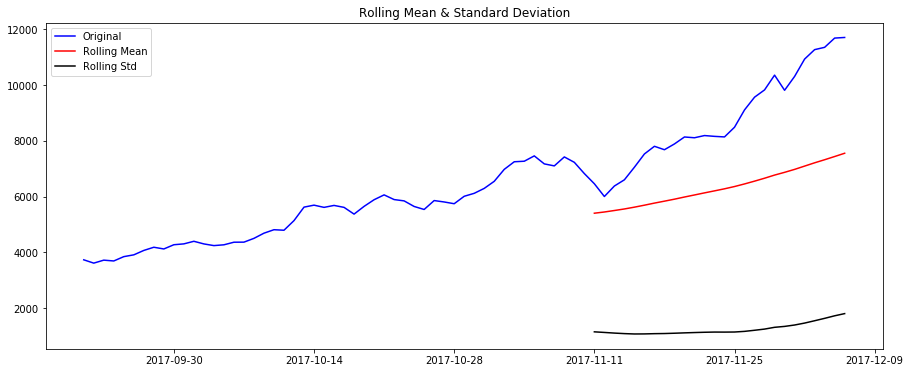

Results of Dickey-Fuller Test:
Test Statistic                  0.950213
p-value                         0.993712
#Lags Used                      1.000000
Number of Observations Used    75.000000
Critical Value (1%)            -3.520713
Critical Value (5%)            -2.900925
Critical Value (10%)           -2.587781
dtype: float64


In [7]:
test_stationarity(ts)

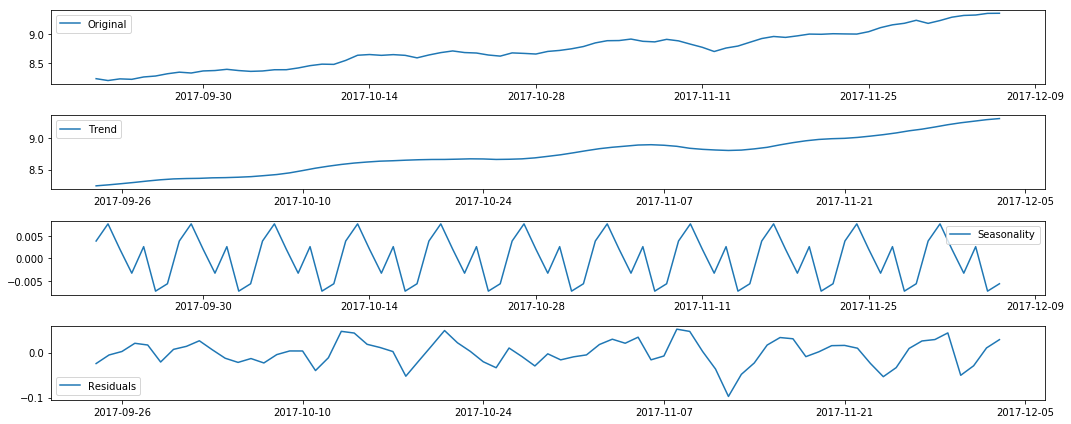

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

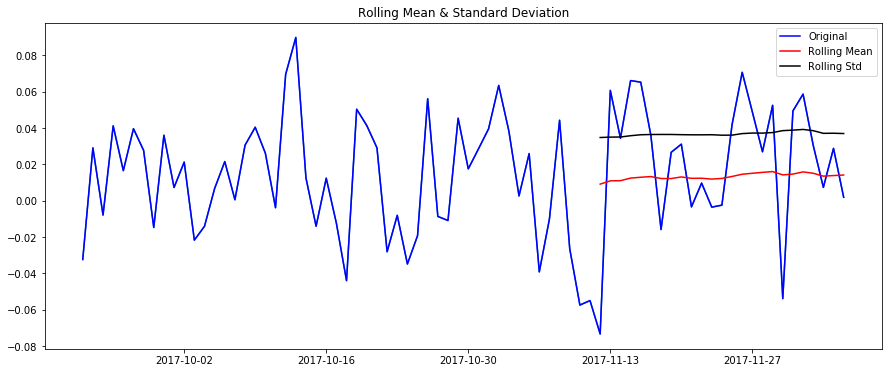

Results of Dickey-Fuller Test:
Test Statistic                -6.862141e+00
p-value                        1.592482e-09
#Lags Used                     0.000000e+00
Number of Observations Used    7.500000e+01
Critical Value (1%)           -3.520713e+00
Critical Value (5%)           -2.900925e+00
Critical Value (10%)          -2.587781e+00
dtype: float64


In [9]:
ts_log = np.log(ts)
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff.index.to_pydatetime(), ts_log_diff.values)
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

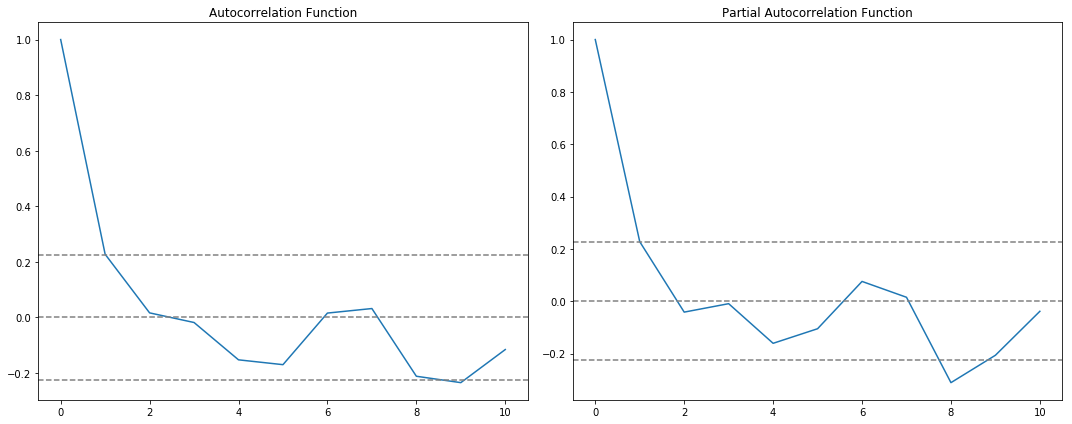

In [10]:
#ACF and PACF plots

lag_acf = acf(ts_log_diff, nlags=10)
lag_pacf = pacf(ts_log_diff, nlags=10, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [11]:
size = int(len(ts_log) - 30)
train, test = ts_log[0:size], ts_log[size:len(ts_log)]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
model = ARIMA(history, order=(13,1,1))
model_fit = model.fit(disp=0)
output = model_fit.forecast(steps=30)
predictions = [np.exp(x) for x in output[0]]

Printing Predicted vs Expected Values...




D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [12]:
forecast = [np.exp(train.tail(1)).iloc[0]] + predictions

In [13]:
dates = pd.date_range('20171106',periods=31)
forecast_series = pd.Series(forecast,index=dates)

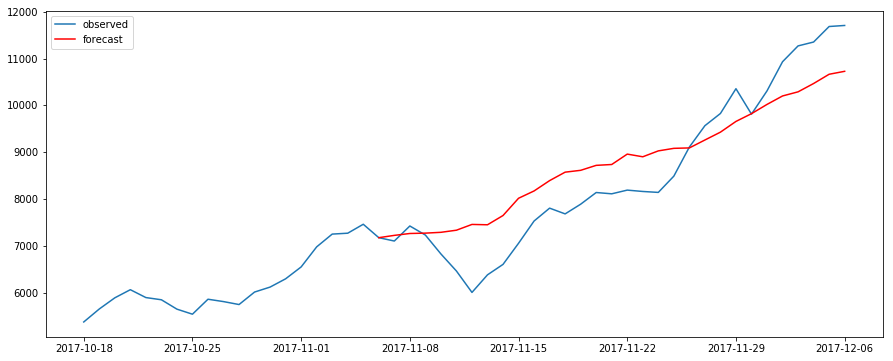

In [14]:
fig, ax = plt.subplots()
ax.plot(ts[-50:], label='observed')
ax.plot(forecast_series, 'r', label='forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')

In [15]:
size = int(len(ts_log))
train, test = ts_log[0:size], ts_log[size:len(ts_log)]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
model = ARIMA(history, order=(13,1,1))
model_fit = model.fit(disp=0)
output = model_fit.forecast(steps=10)
predictions = [np.exp(x) for x in output[0]]

Printing Predicted vs Expected Values...




D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [16]:
forecast = [np.exp(train.tail(1)).iloc[0]] + predictions

In [17]:
dates = pd.date_range('20171206',periods=11)
forecast_series = pd.Series(forecast,index=dates)

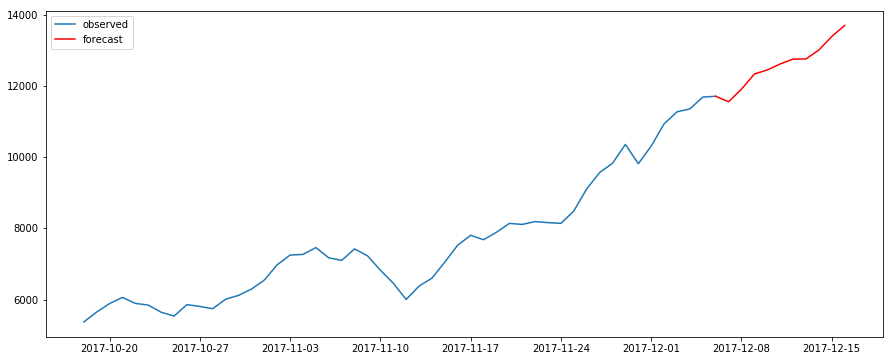

In [18]:
fig, ax = plt.subplots()
ax.plot(ts[-50:], label='observed')
ax.plot(forecast_series, 'r', label='forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')